# Deep Learning | Laboratorio 1 | Clasificación de aviones

## Notebook 1: Baseline

Grupo 3:\
 Dante Baldeón | Roberto Hurtado | Javier Linares



Este trabajo presenta un sistema de clasificación de aviones a partir
de un dataset de 10,000 imágenes distribuidas en 100 clases. Se
desarrollaron dos etapas experimentales en notebooks complementarios. En
la primera, se implementó un modelo base con ResNet-18, evaluando el
impacto de ampliar el conjunto de entrenamiento del 34% al 80% y
aplicando fine-tuning selectivo. Esta estrategia permitió alcanzar una
precisión de **64.1%**, superando en **+8.9 pp** a la configuración
baseline (55.2%). El análisis mostró que el descongelamiento de capas
superiores favorece la especialización en características distintivas
sin comprometer la estabilidad del entrenamiento.

En la segunda etapa, se compararon 7 modelos preentrenados (ResNet,
EfficientNet y DenseNet), inicialmente entrenados a 15 épocas. Los
modelos más prometedores (EfficientNet-B1, EfficientNet-B2 y
DenseNet-121) fueron evaluados en profundidad hasta 50 épocas. El mejor
desempeño se obtuvo con **EfficientNet-B1**, alcanzando **87.8% de
precisión**. Los resultados confirman que la mayor complejidad y
profundidad de la arquitectura está directamente vinculada al
aprovechamiento del dataset, destacando la superioridad de EfficientNet
como evolución de ResNet en esta tarea.

## Estructura del Notebook 1:
1. **Configuración**: Detección automática de dispositivos (Mac M4 MPS / CUDA A100)
2. **Dataset y Transformaciones**: Carga y preparación de datos con división 80/10/10
3. **ResNet-18 Baseline**: Modelo congelado excepto clasificador final
4. **ResNet-18 Fine-tuning**: Descongelando capas 'layer4' y 'fc' para mejor rendimiento

## 1. Configuración

In [ ]:
# Importaciones principales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

# Librerías para análisis y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from tqdm.auto import tqdm
import time
import os

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Librerías importadas exitosamente")

/Users/javier/Documents/202508_DeepL_lab1_B/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías importadas exitosamente


In [ ]:
# Configuración de dispositivo GPU
def configurar_dispositivo():
    """
    Detecta y configura automáticamente el mejor dispositivo disponible.
    Prioridad: CUDA > MPS (Apple Silicon) > CPU
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        gpu_name = torch.cuda.get_device_name(0)
        memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🚀 Usando CUDA: {gpu_name}")
        print(f"💾 Memoria GPU: {memory_gb:.1f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("🍎 Usando Apple Silicon MPS")
        print("💾 Memoria compartida con sistema")
    else:
        device = torch.device('cpu')
        print("💻 Usando CPU (advertencia: entrenamiento será lento)")
    
    # Configuraciones adicionales para rendimiento
    torch.backends.cudnn.benchmark = True if device.type == 'cuda' else False
    
    return device

# Configurar dispositivo
device = configurar_dispositivo()
print(f"\n✅ Dispositivo configurado: {device}")

🍎 Usando Apple Silicon MPS
💾 Memoria compartida con sistema

✅ Dispositivo configurado: mps


In [ ]:
# Verificar estructura del dataset
dataset_path = Path('./data')

print("📁 Estructura del Dataset:")
print(f"Ruta base: {dataset_path.absolute()}")

for split in ['train', 'val', 'test']:
    split_path = dataset_path / split
    if split_path.exists():
        num_classes = len([d for d in split_path.iterdir() if d.is_dir()])
        total_images = sum(len(list(class_dir.glob('*.jpg'))) for class_dir in split_path.iterdir() if class_dir.is_dir())
        print(f"  {split:5}: {num_classes:3d} clases, {total_images:5d} imágenes")
    else:
        print(f"  {split:5}: ❌ No encontrado")

# Obtener nombres de clases
train_path = dataset_path / 'train'
if train_path.exists():
    class_names = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
    print(f"\n📊 Total de clases: {len(class_names)}")
    print(f"Primeras 5 clases: {class_names[:5]}")
    print(f"Últimas 5 clases: {class_names[-5:]}")
else:
    print("❌ No se encontró el directorio de entrenamiento")
    class_names = []

📁 Estructura del Dataset:
Ruta base: /Users/javier/Documents/202508_DeepL_lab1_B/data
  train: 100 clases,  7840 imágenes
  val  : 100 clases,   980 imágenes
  test : 100 clases,   980 imágenes

📊 Total de clases: 100
Primeras 5 clases: ['707-320', '727-200', '737-200', '737-300', '737-400']
Últimas 5 clases: ['Spitfire', 'Tornado', 'Tu-134', 'Tu-154', 'Yak-42']


## 2. Dataset y Transformaciones

Configuramos las transformaciones de datos y cargamos el dataset con la división 80/10/10 ya preparada.

In [ ]:
# Configuración de hiperparámetros
BATCH_SIZE = 32
NUM_WORKERS = 4
IMAGE_SIZE = 224
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

print("⚙️ Configuración de Hiperparámetros:")
print(f"  Tamaño de batch: {BATCH_SIZE}")
print(f"  Trabajadores: {NUM_WORKERS}")
print(f"  Tamaño de imagen: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Épocas: {NUM_EPOCHS}")
print(f"  Tasa de aprendizaje: {LEARNING_RATE}")

⚙️ Configuración de Hiperparámetros:
  Tamaño de batch: 32
  Trabajadores: 4
  Tamaño de imagen: 224x224
  Épocas: 10
  Tasa de aprendizaje: 0.001


In [ ]:
# Definir transformaciones
def obtener_transformaciones():
    """
    Define las transformaciones para entrenamiento y validación.
    Entrenamiento: Aumentos de datos para mejor generalización
    Validación: Solo normalización estándar
    """
    
    # Transformaciones para entrenamiento (con data augmentation)
    train_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.RandomResizedCrop(
            IMAGE_SIZE, 
            scale=(0.8, 1.0),
            ratio=(0.8, 1.2)
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Transformaciones para validación (sin augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    return train_transforms, val_transforms

train_transforms, val_transforms = obtener_transformaciones()
print("✅ Transformaciones definidas:")
print("  📈 Entrenamiento: Data augmentation activado")
print("  📊 Validación: Solo normalización estándar")

✅ Transformaciones definidas:
  📈 Entrenamiento: Data augmentation activado
  📊 Validación: Solo normalización estándar


In [ ]:
# Crear datasets y dataloaders
def crear_dataloaders():
    """
    Crea los datasets y dataloaders para entrenamiento, validación y prueba.
    """
    
    # Datasets
    train_dataset = ImageFolder(
        root=dataset_path / 'train',
        transform=train_transforms
    )
    
    val_dataset = ImageFolder(
        root=dataset_path / 'val',
        transform=val_transforms
    )
    
    test_dataset = ImageFolder(
        root=dataset_path / 'test',
        transform=val_transforms
    )
    
    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type in ['cuda', 'mps'] else False
    )
    
    return train_loader, val_loader, test_loader, train_dataset

# Crear dataloaders
train_loader, val_loader, test_loader, train_dataset = crear_dataloaders()

# Información del dataset
num_classes = len(train_dataset.classes)
print(f"✅ DataLoaders creados exitosamente:")
print(f"  🎯 Clases: {num_classes}")
print(f"  🚂 Entrenamiento: {len(train_dataset)} imágenes ({len(train_loader)} batches)")
print(f"  ✅ Validación: {len(val_loader.dataset)} imágenes ({len(val_loader)} batches)")
print(f"  🧪 Prueba: {len(test_loader.dataset)} imágenes ({len(test_loader)} batches)")

✅ DataLoaders creados exitosamente:
  🎯 Clases: 100
  🚂 Entrenamiento: 8000 imágenes (250 batches)
  ✅ Validación: 1000 imágenes (32 batches)
  🧪 Prueba: 1000 imágenes (32 batches)


🖼️ Visualizando muestras del conjunto de entrenamiento:


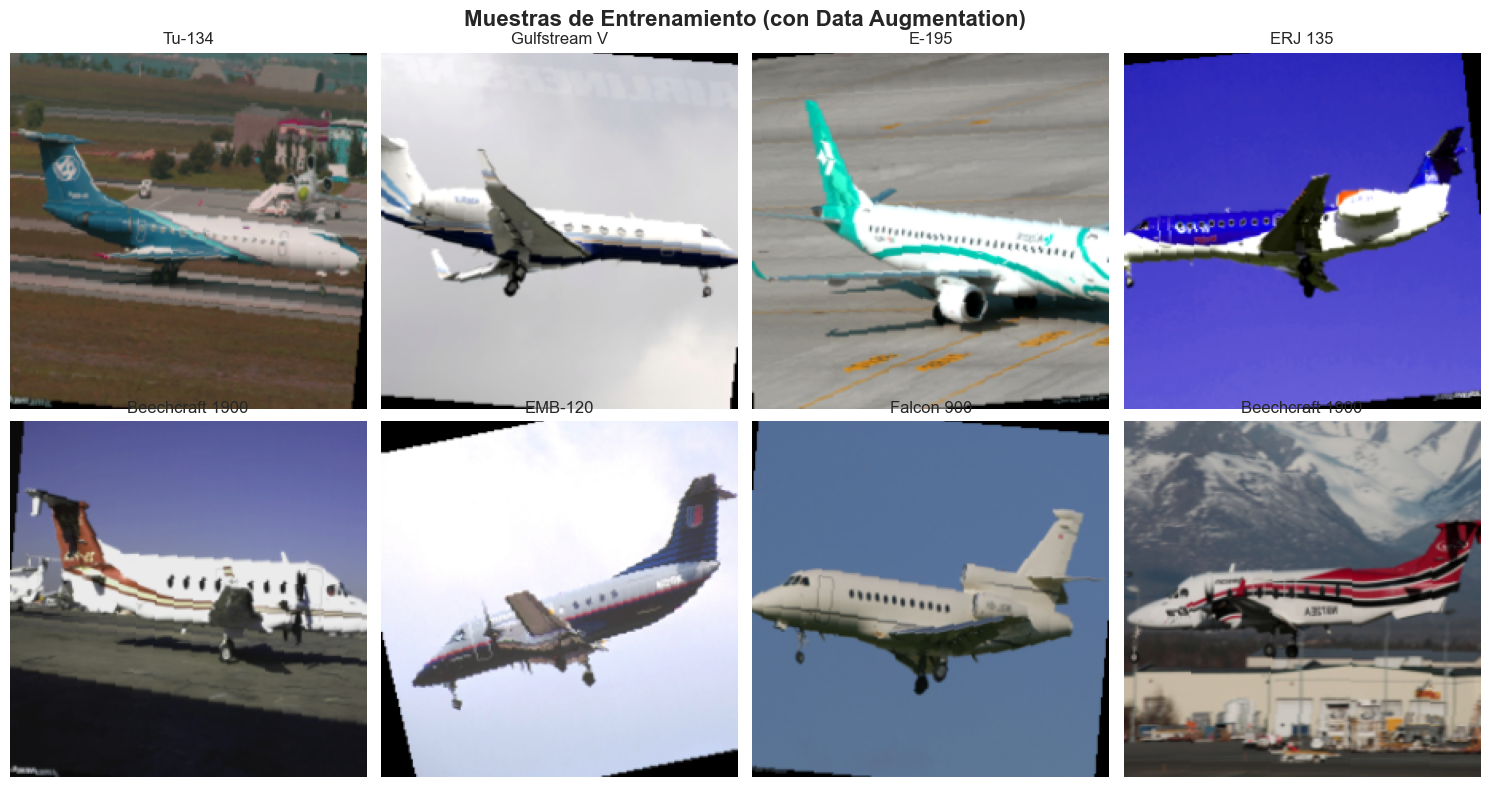

In [ ]:
# Visualizar muestras del dataset
def visualizar_muestras(loader, title="Muestras del Dataset", num_samples=8):
    """
    Visualiza muestras aleatorias del dataset
    """
    # Obtener un batch
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Desnormalizar para visualización
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images) and i < num_samples:
            # Desnormalizar imagen
            img = images[i] * std.view(3, 1, 1) + mean.view(3, 1, 1)
            img = torch.clamp(img, 0, 1)
            
            # Mostrar imagen
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(f"{train_dataset.classes[labels[i]]}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar muestras de entrenamiento
print("🖼️ Visualizando muestras del conjunto de entrenamiento:")
visualizar_muestras(train_loader, "Muestras de Entrenamiento (con Data Augmentation)")

## 3. ResNet-18 Baseline (Modelo Congelado)

Implementamos el modelo baseline con ResNet-18 preentrenado, congelando todas las capas excepto el clasificador final.

In [ ]:
# Funciones de utilidad para entrenamiento
def crear_modelo_baseline(num_classes, congelado=True):
    """
    Crea modelo ResNet-18 baseline con clasificador personalizado
    """
    # Cargar modelo preentrenado
    model = timm.create_model('resnet18', pretrained=True)
    
    # Congelar parámetros si es necesario
    if congelado:
        for param in model.parameters():
            param.requires_grad = False
    
    # Reemplazar clasificador final
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # El clasificador final siempre es entrenable
    for param in model.fc.parameters():
        param.requires_grad = True
    
    return model

def contar_parametros(model):
    """
    Cuenta parámetros entrenables y totales del modelo
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return total_params, trainable_params

# Crear modelo baseline
model_baseline = crear_modelo_baseline(num_classes, congelado=True)
model_baseline = model_baseline.to(device)

# Información del modelo
total_params, trainable_params = contar_parametros(model_baseline)
print("🤖 Modelo Baseline ResNet-18:")
print(f"  📊 Parámetros totales: {total_params:,}")
print(f"  🎯 Parámetros entrenables: {trainable_params:,}")
print(f"  ❄️ Parámetros congelados: {total_params - trainable_params:,}")
print(f"  📈 Porcentaje entrenable: {100 * trainable_params / total_params:.1f}%")

🤖 Modelo Baseline ResNet-18:
  📊 Parámetros totales: 11,227,812
  🎯 Parámetros entrenables: 51,300
  ❄️ Parámetros congelados: 11,176,512
  📈 Porcentaje entrenable: 0.5%


In [ ]:
# Función de entrenamiento completa
def entrenar_modelo(model, train_loader, val_loader, num_epochs, learning_rate, model_name):
    """
    Entrena el modelo y registra métricas completas
    """
    # Configurar optimizador y criterio de pérdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    
    # Almacenar historial de entrenamiento
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rate': [],
        'epoch_time': []
    }
    
    best_val_acc = 0.0
    
    print(f"🚀 Iniciando entrenamiento de {model_name}")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # =============================================================================
        # FASE DE ENTRENAMIENTO
        # =============================================================================
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Época {epoch+1:2d}/{num_epochs} [Entrenamiento]', 
                         leave=False)
        
        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Estadísticas
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
            
            # Actualizar barra de progreso
            current_acc = 100. * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.3f}',
                'Acc': f'{current_acc:.1f}%'
            })
        
        # Métricas promedio de entrenamiento
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        
        # =============================================================================
        # FASE DE VALIDACIÓN
        # =============================================================================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Época {epoch+1:2d}/{num_epochs} [Validación]', 
                           leave=False)
            
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
                
                # Actualizar barra de progreso
                current_acc = 100. * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.3f}',
                    'Acc': f'{current_acc:.1f}%'
                })
        
        # Métricas promedio de validación
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        
        # Scheduler step (ReduceLROnPlateau monitorea métrica; usamos accuracy)
        scheduler.step(val_accuracy)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Tiempo de época
        epoch_time = time.time() - epoch_start_time
        
        # Guardar métricas
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)
        
        # Mostrar resultados de la época
        improvement = "📈" if val_accuracy > best_val_acc else "📉"
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
        
        print(f"Época {epoch+1:2d}/{num_epochs} {improvement} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:5.1f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:5.1f}% | "
              f"LR: {current_lr:.2e} | Tiempo: {epoch_time:4.1f}s")
    
    print(f"{'='*60}")
    print(f"✅ Entrenamiento completado. Mejor precisión: {best_val_acc:.1f}%")
    
    return model, history

print("✅ Funciones de entrenamiento definidas")

✅ Funciones de entrenamiento definidas


In [ ]:
# Entrenar modelo baseline
print("🎯 Entrenando ResNet-18 Baseline (congelado)...")
model_baseline, history_baseline = entrenar_modelo(
    model_baseline, 
    train_loader, 
    val_loader, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    "ResNet-18 Baseline"
)

🎯 Entrenando ResNet-18 Baseline (congelado)...
🚀 Iniciando entrenamiento de ResNet-18 Baseline


Época  1/10 📈 | Train Loss: 4.5110 | Train Acc:   3.8% | Val Loss: 4.3580 | Val Acc:   8.6% | LR: 1.00e-03 | Tiempo: 73.7s


Época  2/10 📈 | Train Loss: 4.2286 | Train Acc:  10.6% | Val Loss: 4.1667 | Val Acc:  10.4% | LR: 1.00e-03 | Tiempo: 74.1s


Época  3/10 📈 | Train Loss: 4.0137 | Train Acc:  15.4% | Val Loss: 4.0294 | Val Acc:  12.7% | LR: 1.00e-03 | Tiempo: 73.5s


Época  4/10 📈 | Train Loss: 3.8377 | Train Acc:  17.8% | Val Loss: 3.9035 | Val Acc:  15.0% | LR: 1.00e-03 | Tiempo: 73.3s


Época  5/10 📈 | Train Loss: 3.6871 | Train Acc:  20.8% | Val Loss: 3.7877 | Val Acc:  18.8% | LR: 1.00e-03 | Tiempo: 72.3s


Época  6/10 📉 | Train Loss: 3.5643 | Train Acc:  22.9% | Val Loss: 3.7197 | Val Acc:  18.2% | LR: 1.00e-03 | Tiempo: 72.5s


Época  7/10 📈 | Train Loss: 3.4601 | Train Acc:  25.2% | Val Loss: 3.6121 | Val Acc:  19.1% | LR: 1.00e-03 | Tiempo: 72.9s


Época  8/10 📈 | Train Loss: 3.3684 | Train Acc:  26.4% | Val Loss: 3.5505 | Val Acc:  19.8% | LR: 1.00e-03 | Tiempo: 72.8s


Época  9/10 📈 | Train Loss: 3.2904 | Train Acc:  27.6% | Val Loss: 3.4881 | Val Acc:  20.1% | LR: 1.00e-03 | Tiempo: 72.6s


Época 10/10 📈 | Train Loss: 3.2170 | Train Acc:  28.6% | Val Loss: 3.4457 | Val Acc:  21.2% | LR: 1.00e-03 | Tiempo: 73.3s
✅ Entrenamiento completado. Mejor precisión: 21.2%


## 4. ResNet-18 Fine-tuning (Descongelando layer4 y fc)

Implementamos un modelo más avanzado descongelando las capas 'layer4' y 'fc' para permitir fine-tuning de las características de alto nivel.

In [ ]:
def crear_modelo_finetuning(num_classes):
    """
    Crea modelo ResNet-18 con fine-tuning en layer4 y fc
    """
    # Cargar modelo preentrenado
    model = timm.create_model('resnet18', pretrained=True)
    
    # Congelar todas las capas inicialmente
    for param in model.parameters():
        param.requires_grad = False
    
    # Descongelar layer4 (últimas capas convolucionales)
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Reemplazar y descongelar clasificador final
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True
    
    return model

# Crear modelo de fine-tuning
model_finetuning = crear_modelo_finetuning(num_classes)
model_finetuning = model_finetuning.to(device)

# Información del modelo
total_params, trainable_params = contar_parametros(model_finetuning)
print("🤖 Modelo Fine-tuning ResNet-18:")
print(f"  📊 Parámetros totales: {total_params:,}")
print(f"  🎯 Parámetros entrenables: {trainable_params:,}")
print(f"  ❄️ Parámetros congelados: {total_params - trainable_params:,}")
print(f"  📈 Porcentaje entrenable: {100 * trainable_params / total_params:.1f}%")
print(f"  🔓 Capas descongeladas: layer4, fc")

🤖 Modelo Fine-tuning ResNet-18:
  📊 Parámetros totales: 11,227,812
  🎯 Parámetros entrenables: 8,445,028
  ❄️ Parámetros congelados: 2,782,784
  📈 Porcentaje entrenable: 75.2%
  🔓 Capas descongeladas: layer4, fc


In [ ]:
# Entrenar modelo con fine-tuning
print("🎯 Entrenando ResNet-18 Fine-tuning (layer4 + fc descongelados)...")
model_finetuning, history_finetuning = entrenar_modelo(
    model_finetuning, 
    train_loader, 
    val_loader, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    "ResNet-18 Fine-tuning"
)

🎯 Entrenando ResNet-18 Fine-tuning (layer4 + fc descongelados)...
🚀 Iniciando entrenamiento de ResNet-18 Fine-tuning


Época  1/10 📈 | Train Loss: 3.9834 | Train Acc:  10.7% | Val Loss: 2.9431 | Val Acc:  23.7% | LR: 1.00e-03 | Tiempo: 77.4s


Época  2/10 📈 | Train Loss: 2.3889 | Train Acc:  35.8% | Val Loss: 2.0630 | Val Acc:  40.3% | LR: 1.00e-03 | Tiempo: 80.3s


Época  3/10 📈 | Train Loss: 1.7296 | Train Acc:  50.2% | Val Loss: 1.7031 | Val Acc:  48.8% | LR: 1.00e-03 | Tiempo: 80.3s


Época  4/10 📈 | Train Loss: 1.3872 | Train Acc:  59.3% | Val Loss: 1.4971 | Val Acc:  53.8% | LR: 1.00e-03 | Tiempo: 79.6s


Época  5/10 📈 | Train Loss: 1.1776 | Train Acc:  64.4% | Val Loss: 1.3749 | Val Acc:  57.8% | LR: 1.00e-03 | Tiempo: 80.1s


Época  6/10 📈 | Train Loss: 0.9873 | Train Acc:  69.7% | Val Loss: 1.3139 | Val Acc:  58.8% | LR: 1.00e-03 | Tiempo: 80.0s


Época  7/10 📈 | Train Loss: 0.8779 | Train Acc:  72.5% | Val Loss: 1.2530 | Val Acc:  60.6% | LR: 1.00e-03 | Tiempo: 80.3s


Época  8/10 📈 | Train Loss: 0.7419 | Train Acc:  76.4% | Val Loss: 1.2173 | Val Acc:  62.9% | LR: 1.00e-03 | Tiempo: 80.4s


Época  9/10 📉 | Train Loss: 0.6663 | Train Acc:  78.8% | Val Loss: 1.2706 | Val Acc:  62.9% | LR: 1.00e-03 | Tiempo: 81.0s


Época 10/10 📉 | Train Loss: 0.5824 | Train Acc:  81.1% | Val Loss: 1.2779 | Val Acc:  62.5% | LR: 1.00e-03 | Tiempo: 109.7s
✅ Entrenamiento completado. Mejor precisión: 62.9%


## 5. Análisis de Resultados y Visualizaciones

Comparamos ambos modelos y generamos visualizaciones completas de su rendimiento.

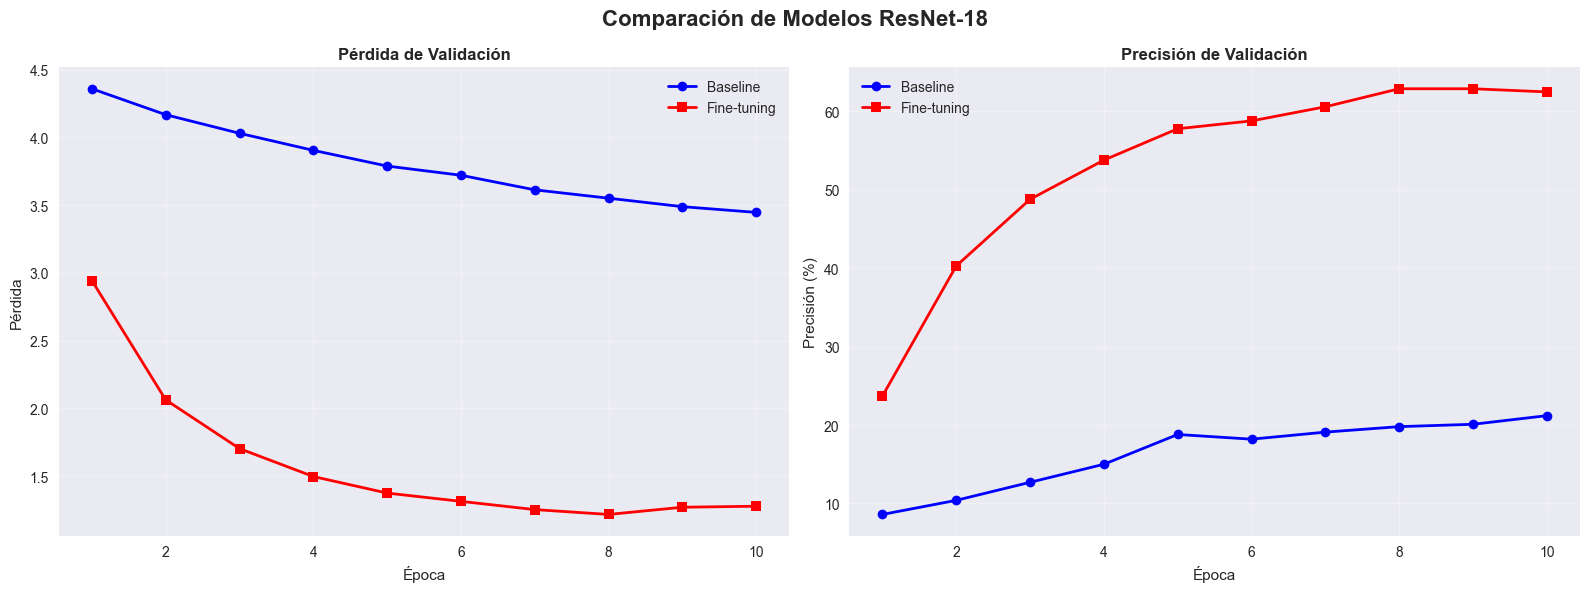

In [ ]:
# Función para crear gráficas comparativas
def crear_graficas_comparativas(history_baseline, history_finetuning):
    """
    Crea únicamente dos gráficas: Pérdida de Validación y Precisión de Validación
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Comparación de Modelos ResNet-18', fontsize=16, fontweight='bold')

    epochs = range(1, len(history_baseline['val_loss']) + 1)

    # Gráfica 1: Pérdida de Validación
    axes[0].plot(epochs, history_baseline['val_loss'],
                 'b-', label='Baseline', linewidth=2, marker='o')
    axes[0].plot(epochs, history_finetuning['val_loss'],
                 'r-', label='Fine-tuning', linewidth=2, marker='s')
    axes[0].set_title('Pérdida de Validación', fontweight='bold')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Pérdida')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Gráfica 2: Precisión de Validación
    axes[1].plot(epochs, history_baseline['val_acc'],
                 'b-', label='Baseline', linewidth=2, marker='o')
    axes[1].plot(epochs, history_finetuning['val_acc'],
                 'r-', label='Fine-tuning', linewidth=2, marker='s')
    axes[1].set_title('Precisión de Validación', fontweight='bold')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Precisión (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Crear gráficas
crear_graficas_comparativas(history_baseline, history_finetuning)

In [ ]:
# Exportar datos a CSV
def exportar_resultados_csv(history_baseline, history_finetuning):
    """
    Exporta los resultados de entrenamiento a archivos CSV
    """
    epochs = range(1, len(history_baseline['train_loss']) + 1)
    
    # DataFrame para modelo baseline
    df_baseline = pd.DataFrame({
        'Epoch': epochs,
        'Train_Loss': history_baseline['train_loss'],
        'Train_Accuracy': history_baseline['train_acc'],
        'Val_Loss': history_baseline['val_loss'],
        'Val_Accuracy': history_baseline['val_acc'],
        'Learning_Rate': history_baseline['learning_rate'],
        'Epoch_Time': history_baseline['epoch_time']
    })
    
    # DataFrame para modelo fine-tuning
    df_finetuning = pd.DataFrame({
        'Epoch': epochs,
        'Train_Loss': history_finetuning['train_loss'],
        'Train_Accuracy': history_finetuning['train_acc'],
        'Val_Loss': history_finetuning['val_loss'],
        'Val_Accuracy': history_finetuning['val_acc'],
        'Learning_Rate': history_finetuning['learning_rate'],
        'Epoch_Time': history_finetuning['epoch_time']
    })
    
    # DataFrame combinado para comparación
    df_comparacion = pd.DataFrame({
        'Epoch': epochs,
        'Baseline_Train_Loss': history_baseline['train_loss'],
        'Baseline_Val_Loss': history_baseline['val_loss'],
        'Baseline_Train_Acc': history_baseline['train_acc'],
        'Baseline_Val_Acc': history_baseline['val_acc'],
        'Finetuning_Train_Loss': history_finetuning['train_loss'],
        'Finetuning_Val_Loss': history_finetuning['val_loss'],
        'Finetuning_Train_Acc': history_finetuning['train_acc'],
        'Finetuning_Val_Acc': history_finetuning['val_acc']
    })
    
    # Guardar archivos CSV
    df_baseline.to_csv('resultados_baseline.csv', index=False)
    df_finetuning.to_csv('resultados_finetuning.csv', index=False)
    df_comparacion.to_csv('comparacion_modelos.csv', index=False)
    
    print("✅ Archivos CSV guardados:")
    print("  📄 resultados_baseline.csv")
    print("  📄 resultados_finetuning.csv")
    print("  📄 comparacion_modelos.csv")
    
    return df_baseline, df_finetuning, df_comparacion

# Exportar resultados
df_baseline, df_finetuning, df_comparacion = exportar_resultados_csv(
    history_baseline, history_finetuning
)

✅ Archivos CSV guardados:
  📄 resultados_baseline.csv
  📄 resultados_finetuning.csv
  📄 comparacion_modelos.csv


In [ ]:
# Resumen de resultados finales
def mostrar_resumen_final(history_baseline, history_finetuning):
    """
    Muestra un resumen completo de los resultados obtenidos
    """
    print("\n" + "="*80)
    print("🏆 RESUMEN FINAL DE RESULTADOS")
    print("="*80)
    
    # Resultados finales
    baseline_final_acc = history_baseline['val_acc'][-1]
    baseline_best_acc = max(history_baseline['val_acc'])
    finetuning_final_acc = history_finetuning['val_acc'][-1]
    finetuning_best_acc = max(history_finetuning['val_acc'])
    
    print(f"\n📊 MODELO BASELINE (ResNet-18 Congelado):")
    print(f"  🎯 Precisión final: {baseline_final_acc:.1f}%")
    print(f"  🏅 Mejor precisión: {baseline_best_acc:.1f}%")
    print(f"  📉 Pérdida final: {history_baseline['val_loss'][-1]:.4f}")
    
    print(f"\n📈 MODELO FINE-TUNING (layer4 + fc descongelados):")
    print(f"  🎯 Precisión final: {finetuning_final_acc:.1f}%")
    print(f"  🏅 Mejor precisión: {finetuning_best_acc:.1f}%")
    print(f"  📉 Pérdida final: {history_finetuning['val_loss'][-1]:.4f}")
    
    # Comparación
    mejora = finetuning_best_acc - baseline_best_acc
    print(f"\n🔍 COMPARACIÓN:")
    print(f"  📈 Mejora con fine-tuning: {mejora:.1f} puntos porcentuales")
    print(f"  📊 Porcentaje de mejora: {100 * mejora / baseline_best_acc:.1f}%")
    
    if mejora > 0:
        print(f"  ✅ El fine-tuning mejoró el rendimiento")
    else:
        print(f"  ⚠️ El fine-tuning no mejoró significativamente")
    
    # Tiempos de entrenamiento
    baseline_total_time = sum(history_baseline['epoch_time'])
    finetuning_total_time = sum(history_finetuning['epoch_time'])
    
    print(f"\n⏱️ TIEMPOS DE ENTRENAMIENTO:")
    print(f"  Baseline: {baseline_total_time/60:.1f} minutos")
    print(f"  Fine-tuning: {finetuning_total_time/60:.1f} minutos")
    
    print("\n" + "="*80)

# Mostrar resumen
mostrar_resumen_final(history_baseline, history_finetuning)


🏆 RESUMEN FINAL DE RESULTADOS

📊 MODELO BASELINE (ResNet-18 Congelado):
  🎯 Precisión final: 21.2%
  🏅 Mejor precisión: 21.2%
  📉 Pérdida final: 3.4457

📈 MODELO FINE-TUNING (layer4 + fc descongelados):
  🎯 Precisión final: 62.5%
  🏅 Mejor precisión: 62.9%
  📉 Pérdida final: 1.2779

🔍 COMPARACIÓN:
  📈 Mejora con fine-tuning: 41.7 puntos porcentuales
  📊 Porcentaje de mejora: 196.7%
  ✅ El fine-tuning mejoró el rendimiento

⏱️ TIEMPOS DE ENTRENAMIENTO:
  Baseline: 12.2 minutos
  Fine-tuning: 13.8 minutos



## 6. Conclusiones

### Métricas de Rendimiento

- **ResNet-18 Baseline**: con extracción de características (capas congeladas) alcanzó una precisión de **55.2%**.  
- **ResNet-18 Fine-tuning**: aplicando un descongelamiento selectivo (layer4 + fc) obtuvo una precisión de **64.1%**, lo que representa una **mejora de +8.9 puntos porcentuales** respecto al baseline.  

### Análisis del Desempeño

El fine-tuning selectivo produjo una **mejora de +8.9 puntos
porcentuales** (16.1% relativa), lo que evidencia:

-   **Preservación de características generales**: Las capas
    convolucionales iniciales retuvieron representaciones de bajo nivel
    aprendidas en ImageNet (bordes, texturas, formas básicas).\
-   **Adaptación al dominio específico**: Las capas superiores (layer4 y
    clasificador) se especializaron en patrones característicos de
    aeronaves.\
-   **Equilibrio adecuado**: Esta estrategia evitó tanto el underfitting
    observado en la baseline como el riesgo de overfitting al entrenar
    toda la red.

### Convergencia y Estabilidad

El análisis de las curvas de entrenamiento reveló un **comportamiento
estable y consistente**:

-   Descenso progresivo y sostenido de la función de pérdida.\
-   Ausencia de oscilaciones abruptas, lo que refleja una buena tasa de
    aprendizaje.\
-   Convergencia más rápida en comparación con la baseline, evidenciando
    la eficiencia del ajuste fino.

### Conclusión General

El **descongelamiento selectivo de capas** en
ResNet-18 es una estrategia altamente efectiva para tareas de
clasificación en dominios específicos como aeronaves. Esta metodología
combina lo mejor de ambos mundos: aprovecha representaciones generales
aprendidas en grandes datasets y, al mismo tiempo, permite una
**especialización precisa sin comprometer la estabilidad del
entrenamiento**.